In [96]:
###############################################
#
#      BIGRAM LLM build with a Neural Network
#
###############################################

import torch
import matplotlib.pyplot as plt

with open('names.txt', 'r') as file:
    names = file.readlines()
names = [name.strip().lower() for name in names] # only lowercase letters to get 26 chars

SPECIAL_CH = '.'

chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i, s in enumerate(chars)} # {'a':1, 'b':2, 'c':3, ..., 'z':26}
# print(stoi)
stoi[SPECIAL_CH] = 0
itos = {i:s for s, i in stoi.items()}

# include counting the special char with the chars in the dataset - 27 total
NUM_CHARS = len(chars + [SPECIAL_CH])

# create a training set of bigrams ( x (1st char),y (2nd char) )

# inputs (xs) and targets (ys)
xs, ys = [], []

for name in names[:1]:
    chs = [SPECIAL_CH] + list(name) + [SPECIAL_CH]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1] # get the number for the char from the stoi dict
        ix2 = stoi[ch2]
        xs.append(ix1) # first chars
        ys.append(ix2) # second chars

# create tensors from the lists of bigrams assembled
xs = torch.tensor(xs) # note: use lowercase tensor() not Tensor() - that one forces the dtype to be float and lowercase tensor() infers the datatype
ys = torch.tensor(ys)

print(f'Int representation of first chars: {xs}') # inputs
print(f'Int representation of second chars: {ys}') # labels (targets)
# When xs[i] (first chars in bigram) is entered we want ys[i] (second chars in bigram) to have a high probability: example: When 0 is entered we want 5 to have a high probability

Int representation of first chars: tensor([ 0,  5, 13, 13,  1])
Int representation of second chars: tensor([ 5, 13, 13,  1,  0])


Unencoded Inputs: tensor([ 0,  5, 13, 13,  1])

Encoded shape: torch.Size([5, 27])
torch.float32
Onehot encoded inputs: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])


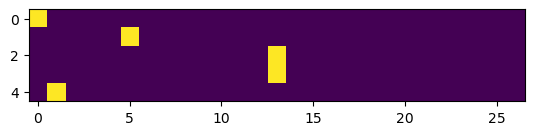

In [97]:
###################
# ONE HOT ENCODING
###################

# Not ideal to pass in integers to neural networks (due to calculations on floats), so we use One Hot Encoding
# We want float values for a nueral net so they can take on various/continuous values
# create a vector made up of dimensions matching the integer and turn the i-th element (the integer index) into a 1
# This vector can feed into a neural net

import torch.nn.functional as F

print(f'Unencoded Inputs: {xs}\n')
# one hot encoding. Pass in the integers you want to encode. num_classes is how many elements in the vector
xenc = F.one_hot(xs, num_classes=NUM_CHARS) # we only need 27 elements in the vector representing 26 letters of the dataset and 1 special token '.'
print(f'Encoded shape: {xenc.shape}') # [5,27] one row for each letter, 27 elements in each vector
# print(xenc.dtype) # int64 - caution!

# cast the returned type from one_hot() to a float (it returns int64 integers, but we need floats to feed into neural nets)
xenc = xenc.float()
print(xenc.dtype)
print(f'Onehot encoded inputs: {xenc}')

plt.imshow(xenc) # visualize the one hot encoded chars
plt.show()

# each row is an example that can be fed into a neural net. The appropriate bit is turned on as a 1 (yellow block) and everything else is 0 (purple blocks)

In [98]:
########## Feed into Neurons ##############

### How matrix multiplication works ###

# Define the weights - use random nums
W = torch.randn((NUM_CHARS,1)) # normally distributed numbers - most will be around 0, and the tails are thin around magnitude of 3,-3
print(f'Weights: {W}\n') # Column vector of 27 (NUM_CHARS) numbers - these will be multiplied by the inputs

# multiply the encoded inputs by the weights using matrix multiplication
print(f'xenc@W: {xenc @ W}\n')

# matrix multiplication of [5, 27] @ [27, 1] takes the 27 cols of input bits (per row) and multiplies by the 27 rows of W (one weight copied 27 times to fill out each row) and takes the sum (dot product)
  # the col values in each of the 5 rows represent the 27 characters and which character is "turned on" - the bit as seen in the above xenc output
# this shows us the five activations on this neuron depending on each of the 5 inputs

turned_on_indices = torch.where(xenc>0) # first tensor = which row, second tensor = which col
print(f'{turned_on_indices=}\n')

# Matrix multiplication goes for all the values in the xenc row, they are multplied by each col value in W in this case (since there is only 1 column each row val goes down the vals element-wise))
  # Most of the values per row in xenc are 0 until we find the bit representing the char that is turned on. This will be a 1. and will be multiplied by the corresponding col value in W - 
  # the sum of the dotproduct will match 1xWcol_val since we only have one col in W
# xenc[0][0] x W[0][0]
# xenc[0][1] x W[1][0]
# xenc[0][2] x W[2][0]
# ...

r = turned_on_indices[0]
c = turned_on_indices[1]
print(f'First char bit turned on (={xenc[r[0]][c[0]]}): row={r[0]},col={c[0]} = corresponding weight val {W[c[0]][0]:.4f} = row {c[0]} in W')
print(f'Second char bit turned on (={xenc[r[1]][c[1]]}): row={r[1]},col={c[1]} = corresponding weight val {W[c[1]][0]:.4f} = row {c[1]} in W')


Weights: tensor([[ 1.4486],
        [-0.6717],
        [-0.3561],
        [ 1.5203],
        [ 1.4628],
        [-1.3405],
        [-0.9905],
        [ 0.2023],
        [-1.2606],
        [ 0.4803],
        [-0.1919],
        [ 0.0522],
        [-0.1476],
        [-0.3931],
        [-0.1939],
        [ 0.2726],
        [-1.1932],
        [-0.5474],
        [ 0.7891],
        [ 1.4749],
        [ 0.8353],
        [ 0.7368],
        [-1.2107],
        [-1.4825],
        [-1.7544],
        [-1.5090],
        [-1.9375]])

xenc@W: tensor([[ 1.4486],
        [-1.3405],
        [-0.3931],
        [-0.3931],
        [-0.6717]])

turned_on_indices=(tensor([0, 1, 2, 3, 4]), tensor([ 0,  5, 13, 13,  1]))

First char bit turned on (=1.0): row=0,col=0 = corresponding weight val 1.4486 = row 0 in W
Second char bit turned on (=1.0): row=1,col=5 = corresponding weight val -1.3405 = row 5 in W


In [99]:
# The above is for one neuron, but we want more neurons which represent one layer in a neural net

# weights
W = torch.randn(NUM_CHARS, NUM_CHARS) # 27x27 - first arg is the column of weight values to use, the second argument represents the number of neurons
# [ [...weights], [...for which neuron] ] - rows = weights, cols = neurons

dot_prods = xenc @ W # now we have a 5x27 matrix (the five onehot encoded inputs to the NN multiplied by  )

# this shows the dot product of the third input and the 13th column of the W (weights) matrix
print(f'Firing rate of 14th neuron looking at 4th input (row): {dot_prods[3,13]}\n')
# the firing rate is the dot product of that intput (the row values of xenc) multiplied by the weights (column values) for that neuron:
print(f'xenc 4th row: {xenc[3]}\n')
print(f'W 14th column: {W[:,13]}')
# print(f'Dot product of 4th input against 13th col of W: {xenc[3] @ W[:,13]}')
print(f'Dot product of 4th input against 13th col of W: {(xenc[3] * W[:,13]).sum()}') # should match firing rate printed above

### This matrix multiplication allows us to look at multiple input examples input into a layer of neurons in a neural net (i.e. 27 inputs into a layer of 27 neurons here)
## NOTE: This layer is a linear layer (there is no bias or squashing function like tanh applied, just weights x inputs).
        # This NN is also going to be just one layer (as simple as possible NN)

print(f'\nInputs x Weights (27 neurons): {dot_prods}')

Firing rate of 14th neuron looking at 4th input (row): -1.1339048147201538

xenc 4th row: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

W 14th column: tensor([ 0.2373,  0.4346,  0.6916,  0.2275, -1.0118,  0.0521,  0.5254,  0.4825,
         0.2600,  0.0154,  2.0296,  0.5192,  0.6778, -1.1339, -1.1208, -1.2048,
         0.2204,  0.3787,  1.3834, -0.1648,  2.1482, -0.2642, -0.5372,  0.9618,
        -0.7203, -0.8568, -0.9573])
Dot product of 4th input against 13th col of W: -1.1339048147201538

Inputs x Weights (27 neurons): tensor([[-1.2193,  0.0690, -1.3106, -1.1039,  1.0090, -0.6649, -0.0892, -1.2055,
          0.6764,  1.4185, -1.1270,  1.0709, -0.4315,  0.2373, -0.1926,  1.1851,
         -1.4457,  0.6543,  2.1094, -0.0901, -1.0851,  0.5153, -0.8900, -0.9564,
         -0.8416,  0.0073,  0.2569],
        [ 0.4350,  1.7677, -0.7730, -0.2444, -0.7829, -0.8570, -0.6158,  0.9353,
         -0.3553,  1.0593, -1.52

In [100]:
########### EXPONENTIATION TO USE FOR GETTING LOG COUNTS OF CHARACTERS ###################


'''
We need a probability distribution for what the next character could be given a character input.

Because integers are not ideal in NN input, we cannot use integer counts per char (as in the original non-neural net example of a bigram - see ./bigramllm.ipynb).
We therefore use log counts (i.e. 'logits') - we use exponentiatiation of the weight x input dot product outputs of the neural layer to get the log counts.

Exponentation: see https://www.wolframalpha.com/input?i=exp%28x%29

If negative number input, you will get e^x which is always positive and below +1
If positive number input, you get numbers greater than +1 to positive infinity

We can use this exponentiated log count to represent the count per character that we used originally.
'''

print('exponentiated values -3.0 and 5.0:')
t = torch.tensor([-3.0,5.0])
print(t.exp()[0].item()) # exponentiation: negative input results in positive number below 1
print(t.exp()[1].item()) # exponentiation: positive input results in positive number even higher than the input (and greater than 1)
print('\n')


exponentiated values -3.0 and 5.0:
0.049787066876888275
148.4131622314453




In [101]:
# Get the log counts for the neural net layer:
logits = xenc @ W # log-counts (the inputs, which bit is on representing the character in the set, multiplied by the weights - each col is the dot product per neuron in the layer)
counts = logits.exp() # exponentiated logits: make any negatives positive (to better represent counts), this is equivalent to and can be interpreted as the counts per char
print(f'All counts: {counts}') # all will be positive numbers due to the exponentation of the dot product outputs (if they were negative)
# NOTE: all of these are differentiable operations that we can back propagate through (i.e. use gradient descent)

s = counts.sum(1, keepdim=True) # get sum per row (1st dimension)
print(f'\nSum of counts per row: {s}')

# Probabilities using the count normalized by the sum of counts in the row:
probs = counts / counts.sum(1, keepdim=True)
print(f'\nProbabilities (count / row_sum): {probs}') # every row sums to 1.0


All counts: tensor([[ 0.2954,  1.0714,  0.2697,  0.3316,  2.7427,  0.5143,  0.9146,  0.2995,
          1.9667,  4.1308,  0.3240,  2.9180,  0.6495,  1.2679,  0.8248,  3.2709,
          0.2356,  1.9238,  8.2431,  0.9139,  0.3379,  1.6741,  0.4107,  0.3843,
          0.4310,  1.0073,  1.2929],
        [ 1.5450,  5.8576,  0.4616,  0.7832,  0.4571,  0.4244,  0.5402,  2.5479,
          0.7010,  2.8845,  0.2169,  0.6776,  2.8877,  1.0534,  0.8339,  0.0435,
          0.1347,  1.7399,  6.7861,  1.4401,  0.5840,  0.1493,  0.2473,  2.1164,
          0.5903,  0.3715,  1.6169],
        [ 0.0984,  1.0711,  1.0897,  0.6590,  0.2957,  1.3104,  0.5489,  0.8174,
          0.5757,  0.8244,  0.7643,  1.8132,  0.2490,  0.3218,  4.0904,  0.7288,
          1.3787,  0.7071,  0.3183, 11.0466,  0.2589, 16.1432,  1.8270,  0.3185,
          0.6786,  1.8449,  0.6000],
        [ 0.0984,  1.0711,  1.0897,  0.6590,  0.2957,  1.3104,  0.5489,  0.8174,
          0.5757,  0.8244,  0.7643,  1.8132,  0.2490,  0.3218,  4.0

In [124]:
# we now have 27 numbers for each input (i.e. a single char fed into the neural net)
i = 0 # first row representing the input of the first character `.` - xs[0]
print(f'Input char: {itos[i]}')
print(f'Probabilities of which char comes after char input: \n\t{[round(n.item(), 4) for n in probs[i]]}\n')
print(probs[i].sum()) # normalized to probs so they all sum to 1.0



Input char: .
Probabilities of which char comes after char input: 
	[0.0076, 0.0277, 0.007, 0.0086, 0.071, 0.0133, 0.0237, 0.0078, 0.0509, 0.1069, 0.0084, 0.0755, 0.0168, 0.0328, 0.0213, 0.0846, 0.0061, 0.0498, 0.2133, 0.0236, 0.0087, 0.0433, 0.0106, 0.0099, 0.0112, 0.0261, 0.0335]

tensor(1.)
